# Optical Illusion with text-to-image Diffusion
Optical illusion is a visual phenomenon that tricks the brain into perceiving something that isn't there or misinterpreting the true nature of an image.

This code uses a pretrained diffusion model to generate such images, focusing on different contents from various perspectives.


## Hugging Face Access
In this homework, we deploy a `pixel-based` diffusion model named [DeepFloyd IF](https://huggingface.co/docs/diffusers/api/pipelines/deepfloyd_if). Therefore, it's necessary to obtain the access token from Hugging Face, please follows these steps below:

1. Make sure to have a [Hugging Face account](https://huggingface.co/join) and be logged in.
2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0).
3. Log in locally by entering your [Hugging Face Hub access token](https://huggingface.co/docs/hub/security-tokens#what-are-user-access-tokens) below, which can be [found here](https://huggingface.co/settings/tokens).

In [1]:
from huggingface_hub import login

##############################
# TODO2-0: Fill your acess token
# Begin your code
token = ""
# End your code
##############################

login(token=token)

## Install Dependencies
Run the cell below to install the required dependencies. You can skip this step if the environment is already setup.

In [2]:

! pip install -q   \
    diffusers      \
    transformers   \
    safetensors    \
    sentencepiece  \
    accelerate     \
    bitsandbytes   \
    einops         \
    mediapy        \
    python-time    \
    pillow


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.4 MB/s eta 0:00:00:00:0100:01


## Import Dependencies and Misc Setup
We import packages we need and define some useful functions

In [3]:
import os
import gc
import torch
import mediapy as mp
from time import sleep


# Convert image ([-1,1] GPU) into image ([0,255] CPU)
def im_to_np(im):
    im = (im / 2 + 0.5).clamp(0, 1)
    im = im.detach().cpu().permute(1, 2, 0).numpy()
    im = (im * 255).round().astype("uint8")
    return im


# Garbage collection function to free memory
def flush():
    sleep(1)
    gc.collect()
    torch.cuda.empty_cache()


# Set up device
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device}")

Current Device: cuda


## Load T5 TextEncoder Model
We will load the `T5` text model in half-precision (`fp16`), use it to encode some prompts, and then delete it to recover GPU memory. Note that downloading the model may take a minute or two.

In [4]:
from transformers import T5EncoderModel
from diffusers import DiffusionPipeline

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    subfolder="text_encoder",
    device_map=None,
    variant="fp16",
    torch_dtype=torch.float16,
)

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=text_encoder,  # pass the previously instantiated text encoder
    unet=None
)
pipe = pipe.to(device)

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

model.safetensors.index.fp16.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

model.fp16-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model.fp16-00002-of-00002.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


##  Create Text Embeddings

We can now use the T5 model to embed prompts for our optical illusion. It may be a good idea to embed a few prompts that you want to use, given that we will delete the T5 text encoder in the next block. See the commented out code for an example of how to do this.

In [5]:
##############################
# TODO2-1: Prompt Design
# Begin your code
prompt_1 = "A painting of a spaceship flying above the Earth, with a dark starry sky background. The Earth is fully visible and centered. The spaceship is positioned above the Earth."
prompt_2 = "A painting of a hot air balloon floating in the sky, with a dark starry sky background. The balloon is fully visible and centered. A small basket is attached below the balloon."D
# End your code
##############################

# Embed prompts using the T5 model
prompts = [prompt_1, prompt_2]
prompt_embeds = [pipe.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds = torch.cat(prompt_embeds)
negative_prompt_embeds = torch.cat(negative_prompt_embeds)  # These are just null embeds

## Viewing Transformation
To generate multi-view optical illusions, we need to predefine the viewing transformation for the `denoising process`. However, there are some `constraints` on the transformation matrix, including the properties of being `invertible, linear, and orthogonal`. You don't need to worry about these constraints in this homework, but understanding them can be helpful if you want to explore different viewing effects.

In [6]:
import torchvision.transforms as T

##############################
# TODO2-2: Viewing Transformation
# Begin your code

# views = [IdentityView(), Rotate180View()]
class IdentityView:
    def __init__(self):
        pass
    def view(self, im):
        return im
    def inverse_view(self, noise):
        return noise

class Rotate180View:
    def __init__(self):
        pass
    def view(self, im):
        if isinstance(im, torch.Tensor):
            return im.flip(-1, -2)
        else:
            return im.rotate(180)
    def inverse_view(self, noise):
        if isinstance(noise, torch.Tensor):
            return noise.flip(-1, -2)
        else:
            return noise.rotate(180)

views = [IdentityView(), Rotate180View()]

# End your code
##############################

## Delete the Text Encoder

We now delete the text encoder (and the `diffusers` pipeline) and flush to free memory for the DeepFloyd image generation model.

In [7]:
del text_encoder
del pipe
flush()

## Main Diffusion Process

With our now released and available GPU memory, we can load the various DeepFloyd IF diffusion models (also at `float16` precision). This may take a minute of two.

In [8]:
from diffusers import DiffusionPipeline

# Load DeepFloyd IF stage I
stage_1 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-I-L-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
            ).to(device)

# Load DeepFloyd IF stage II
stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-L-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
            ).to(device)

# Load DeepFloyd IF stage III
# (which is just Stable Diffusion 4x Upscaler)
stage_3 = DiffusionPipeline.from_pretrained(
                "stabilityai/stable-diffusion-x4-upscaler",
                torch_dtype=torch.float16
            ).to(device)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Denoising Operation
In the vanila DeepFloyd IF, it can directly apply stage_1, stage_2, and stage_3 sequentially to compute an $1024 \times 1024$ image that related to prompt. Nevertheless, in both stage_1 and stage_2, we need to compute noises from different views and apply them on noisy image.

In [9]:
from tqdm import tqdm

import torch

##############################
# TODO2-3: Denoising Operation
# The following code only computes and applies the noise
# from the first prompt and original view. Please revise
# the denoising process according to spec.

# Begin your code

@torch.no_grad()
def denoising_loop(model, noisy_images, prompt_embeds, views, 
                   timesteps, guidance_scale, generator, noise_level=None, upscaled=None):
    
    num_views = len(views)
    assert prompt_embeds.shape[0] == 2 * num_views

    # neg / pos
    neg_embeds, pos_embeds = prompt_embeds.split(num_views)

    if noise_level is not None:
        noise_level = torch.cat([noise_level] * 2)

    for t in tqdm(timesteps):
        view_preds = []

        for v_idx, view in enumerate(views):
            cur_prompt = torch.stack([
                neg_embeds[v_idx],
                pos_embeds[v_idx]
            ])  

            if upscaled is not None:
                img_in = torch.cat([
                    view.view(noisy_images),
                    view.view(upscaled)
                ], dim=1)
            else:
                img_in = view.view(noisy_images)

            
            img_in = torch.cat([img_in, img_in], dim=0)
            img_in = model.scheduler.scale_model_input(img_in, t)

            
            noise_pred = model.unet(
                img_in, t,
                encoder_hidden_states=cur_prompt,
                class_labels=noise_level,
                cross_attention_kwargs=None,
                return_dict=False
            )[0]

            noise_uncond, noise_cond = noise_pred.chunk(2, dim=0)
            C = img_in.shape[1] // (2 if upscaled is not None else 1)
            noise_u, _      = noise_uncond.split(C, dim=1)
            noise_c, var_c  = noise_cond.split(C, dim=1)
            noise_out = noise_u + guidance_scale * (noise_c - noise_u)
            pred = torch.cat([noise_out, var_c], dim=1)
            view_preds.append(view.inverse_view(pred))

        if num_views == 2:
            p0, p1 = view_preds
            C_total = p0.shape[1]
            noise0, var0 = p0[:, :C], p0[:, C:]
            noise1, var1 = p1[:, :C], p1[:, C:]

            interleaved = torch.zeros_like(noise0)
            interleaved[:, 0::2, ...] = noise0[:, 0::2, ...]
            interleaved[:, 1::2, ...] = noise1[:, 1::2, ...]

            var_avg = (var0 + var1) * 0.5
            noise_pred_avg = torch.cat([interleaved, var_avg], dim=1)

        else:
            noise_pred_avg = torch.mean(torch.stack(view_preds, dim=0), dim=0)

        noisy_images = model.scheduler.step(
            noise_pred_avg, t, noisy_images,
            generator=generator,
            return_dict=False
        )[0]

    return noisy_images



# End your code
##############################

In [10]:
import torch
import torch.nn.functional as F

from diffusers.utils.torch_utils import randn_tensor

@torch.no_grad()
def adjusted_stage_1(model, prompt_embeds, negative_prompt_embeds, views,
                   num_inference_steps=100, guidance_scale=7.0, generator=None):

    num_prompts = prompt_embeds.shape[0]
    assert num_prompts == len(views), \
        "Number of prompts must match number of views!"
    
    height = model.unet.config.sample_size
    width = model.unet.config.sample_size

    # For CFG
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Setup timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.scheduler.timesteps

    # Make intermediate_images
    noisy_images = model.prepare_intermediate_images(
        1, model.unet.config.in_channels, height, width, prompt_embeds.dtype, device, generator,
    )

    return denoising_loop(model, noisy_images, prompt_embeds, views, 
                          timesteps, guidance_scale, generator)


@torch.no_grad()
def adjusted_stage_2(model, image, prompt_embeds, negative_prompt_embeds, views,
                   num_inference_steps=100, guidance_scale=7.0, noise_level=50, generator=None):

    num_prompts = prompt_embeds.shape[0]
    assert num_prompts == len(views), \
        "Number of prompts must match number of views!"
        
    height = model.unet.config.sample_size
    width = model.unet.config.sample_size
    num_images_per_prompt = 1

    # For CFG
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Get timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.scheduler.timesteps

    num_channels = model.unet.config.in_channels // 2
    noisy_images = model.prepare_intermediate_images(
        1, num_channels, height, width, prompt_embeds.dtype, device, generator,
    )

    # Prepare upscaled image and noise level
    image = model.preprocess_image(image, num_images_per_prompt, device)
    upscaled = F.interpolate(image, (height, width), mode="bilinear", align_corners=True)

    noise_level = torch.tensor([noise_level] * upscaled.shape[0], device=upscaled.device)
    noise = randn_tensor(upscaled.shape, generator=generator, device=upscaled.device, dtype=upscaled.dtype)
    upscaled = model.image_noising_scheduler.add_noise(upscaled, noise, timesteps=noise_level)

    return denoising_loop(model, noisy_images, prompt_embeds, views, 
                          timesteps, guidance_scale, generator, noise_level, upscaled)

## Generate Illusions
Now, we can sample illusions by denoising multiple views at once. The `adjusted_stage_1` function does this and generates a $64 \times 64$ image. The `adjusted_stage_2` function upsamples the resulting image while denoising all views, and generates a $256 \times 256$ image.

Finally, `stage_3` simply upsamples the $256 \times 256$ image using a single given text prompt to $1024 \times 1024$, _without_ doing multi-view denoising.

100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


,

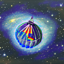
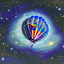

In [11]:
image_64 = adjusted_stage_1(stage_1, prompt_embeds, negative_prompt_embeds, views,
                          num_inference_steps=30, guidance_scale=15.0, generator=None)

# Show result
mp.show_images([im_to_np(view.view(image_64[0])) for view in views])

100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


,

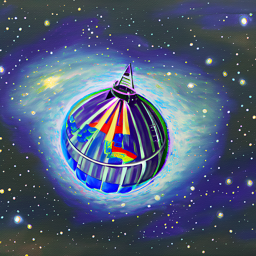
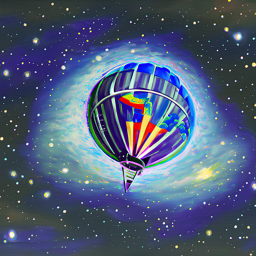

In [12]:
image_256 = adjusted_stage_2(stage_2, image_64, prompt_embeds, negative_prompt_embeds, views,
                           num_inference_steps=30, guidance_scale=15.0, noise_level=50, generator=None)

# Show result
mp.show_images([im_to_np(view.view(image_256[0])) for view in views])

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:704: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

,

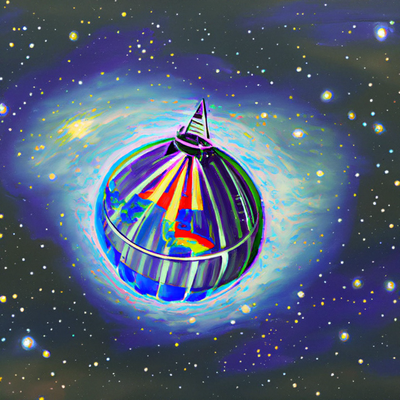
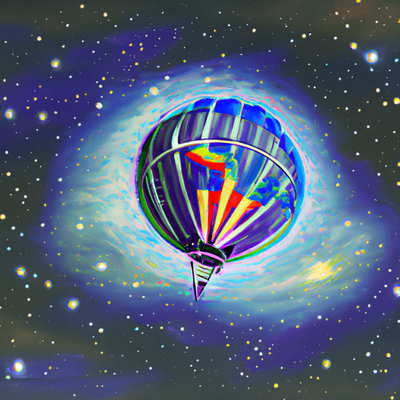

In [13]:
image_1024 = stage_3(prompt=prompts[0], image=image_256,
                noise_level=0, output_type='pt', generator=None).images
image_1024 = image_1024 * 2 - 1

# Limit display size, otherwise it's too large for most screens
mp.show_images([im_to_np(view.view(image_1024[0])) for view in views], width=400)
mp.write_image('result.jpg', im_to_np(image_1024[0]))

## Delete the Stages and Images
We now delete the stages for DeepFloyd image generation and flush to free memory for the CLIP score evaluation.

In [14]:
del stage_1
del stage_2
del stage_3
flush()

del image_64
del image_256
del image_1024
flush()

## CLIP Score
This is an evaluation for optical illusion images. A higher score indicates that the text and image are more `closely related`. To ensure the image quality, the score of each image, after applying viewing transformations and comparing it to the corresponding text, `must exceed 0.3`.

Note that you can `regenerate` the optical illusion image using the same code until the score is high enough.

In [15]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
path = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(path)
processor = CLIPProcessor.from_pretrained(path)

# Define images and texts
image_path = "result.jpg"
texts = [prompt_1, prompt_2]

image = Image.open(image_path)
images = [view.view(image) for view in views]

# Preprocess
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

# Use CLIP to compute the embedding
outputs = model(**inputs)
image_features = outputs.image_embeds
text_features = outputs.text_embeds

# Calculate the cosine similarities (images <-> texts) with embeddings
cosine_similarities = torch.nn.functional.cosine_similarity(image_features, text_features, dim=-1)

for text, score in zip(texts, cosine_similarities):
    print(f"Prompt: {text}")
    print(f"CLIP Score: {score:.4f}\n")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Prompt: A painting of a spaceship flying above the Earth, with a dark starry sky background. The Earth is fully visible and centered. The spaceship is positioned above the Earth.
CLIP Score: 0.3309

Prompt: A painting of a hot air balloon floating in the sky, with a dark starry sky background. The balloon is fully visible and centered. A small basket is attached below the balloon.
CLIP Score: 0.3904

